In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.50'

import jax
import jax.numpy as jnp

import haiku as hk

from functools import partial

import numpy as np

from sde4mbrl.nsde import ControlledSDE, create_sampling_fn, create_model_loss_fn
from sde4mbrl.train_sde import train_model

from tqdm.auto import tqdm
import time

import matplotlib.pyplot as plt

%matplotlib widget

# Magic IPython deepreloading...
%reload_ext autoreload
%autoreload 2
import builtins
from IPython.lib import deepreload
builtins.reload = deepreload.reload

%autoreload

In [2]:
# A simple linear stochastic system with known dynamics
class LinSDE(ControlledSDE):
    def __init__(self, params, name=None):
        # Define the params here if needed before initialization
        super().__init__(params, name)
    
    # The dynamics is known so the prior function is equal 
    # to the posterior function
    def prior_drift(self, t, x, u):
        return 3*x + u
    
    # We set the posterior function to be the same as the prior function
    posterior_drift = prior_drift
    
    # The noise in the dynamics
    def prior_diffusion(self, t, x):
        return jnp.array([4.])

In [3]:
# The neural SDE representation of the system
# This is done with fixed diffusion term, big enough so that the prior encapsulate the full dynamics
# And the posterior must be learned so that the diffusion is controlled around the measured states
class MySDE(ControlledSDE):
    def __init__(self, params, name=None):
        # Define the params here if needed before initialization anythin else
        super().__init__(params, name)
        self.init_DNNs()

    def prior_drift(self, t, x, u):
        # We don't known much about the drift term
        return jnp.zeros_like(x)

    def prior_diffusion(self, t, x):
        # The noise initially is set to large value 8
        # This helps to have prior cover mostly the solution
        return jnp.array([8.]) # * jnp.exp(prior_nn)

    def posterior_drift(self, t, x, u):
        # The posterior is defined as a control affine dynamycs
        return self.f(t,x) + self.G_fn(t,x) @ u

    def init_DNNs(self):
        """ Initialize the neural network models to be used, usually control-affine setup"""
        # NN for the prior diffusion term
        self.prior_nn = hk.get_parameter("diff", shape=(1,),
                            init=hk.initializers.RandomUniform(minval=-1e-2,maxval=1e-2))
        # NN for the function f and G in f(x) + G(x) u
        self.f_nn = hk.nets.MLP(output_sizes=(5,1),
                            w_init=hk.initializers.RandomUniform(minval=-1e-3, maxval=1e-3),
                            b_init=jnp.zeros, activation=jnp.tanh, name='f')
        self.G_nn = hk.nets.MLP(output_sizes=(5,1),
                            w_init=hk.initializers.RandomUniform(minval=-1e-3, maxval=1e-3),
                            b_init=jnp.zeros, activation=jnp.tanh, name='G')
        self.G_fn = lambda t, x: self.G_nn(x).reshape((-1, self.params['n_u']))
        self.f = lambda t, x: self.f_nn(x)

In [4]:
# Create few trajectories based on a subptimal control
def create_data_trajectories(params_model, num_trajectories, seed=10):
    # Create a random key generator and parse it for state initialization
    rng_key = jax.random.PRNGKey(seed)
    rng_key, init_x_key, noisy_traj_key = jax.random.split(rng_key, 3)
    
    # Define a suboptimal policy to use when generating the dataset
    def u_subopt(t, x):
        return ((3*jnp.exp(8*t-8) - 7)*x / (1 + 3*jnp.exp(8*t-8))) * jnp.exp(2*(t-1))

    # Create function for predicting trajectories based on the known dynamics
    prior_params, sampling_fn = create_sampling_fn(params_model, sde_constr=LinSDE,
                    prior_sampling=False, seed=0)

    # Jit the sampling function for a suboptimal control
    jit_sampling = jax.jit(lambda t, x, rng_val:  sampling_fn(prior_params, t, x, u_subopt, rng_val))

    # Initial state values
    init_x = jax.random.uniform(init_x_key, (num_trajectories, 1), minval=0.3, maxval=0.7)

    # Generate the different time evolution
    step_size = 0.01
    num_points = 100
    dur_traj = int(num_points * step_size)
    init_rng, traj_length_rng = jax.random.split(noisy_traj_key)
    # t0_val = jax.random.uniform(init_rng, (num_trajectories,), minval=0., maxval=0.2)
    t0_val = jnp.zeros((num_trajectories,))
    tevol = jax.vmap(lambda t : jnp.linspace(t, t+dur_traj, num_points))(t0_val)

    rng_key = jax.random.split(rng_key, num_trajectories)
    state_data, uval = jax.vmap(jit_sampling)(tevol, init_x, rng_key)
    state_data = state_data.reshape((-1, tevol.shape[1], init_x.shape[1]))
    uval = uval.reshape((-1, uval.shape[-2], uval.shape[-1]))
    # uval = u_subopt(tevol.reshape((*tevol.shape, 1)), state_data)
    res =  {'y' : state_data, 't' : tevol, 'u' : uval}
    # Set it as a list of numpy arrays as it will usually be the case
    # Save as an np so that it is loaded on the CPU instead of GPU
    return { k : [ np.array(v[i]) for i in range(v.shape[0])] for k, v in res.items()}


# Generate the trajectories that are going to be used for learning
_stupid_params = {'sde_solver' : 'stratonovich_milstein', 'n_y' : 1, 'n_u' : 1, 'n_x' : 1, 'num_particles' : 1}
dataset = create_data_trajectories(_stupid_params, 1000, seed=10)

In [5]:
import yaml

# Open the yaml file containing the configuration to train the model
yml_file = open('config_linreg.yaml')
yml_byte = yml_file.read()
m_config = yaml.load(yml_byte, yaml.SafeLoader)
yml_file.close()
print(m_config)

# When to stop the gradient descent -> Typically when no improvement for a fixed number of steps
no_improv = m_config['training']['no_improvement_bound']
improved_est = lambda curr_opt, test_opt, train_opt: \
                    curr_opt['Loss'] > test_opt['Loss'] + no_improv

{'model': {'n_y': 1, 'n_u': 1, 'n_x': 1, 'num_particles': 100, 'num_particles_online_control': 1000, 'num_particles_learning_sde': 100, 'num_particles_valuefun_learning': 100, 'sde_solver': 'stratonovich_milstein'}, 'apg_mpc': {'stepsize': 10.0, 'max_iter': 10, 'moment_scale': None, 'beta_init': 0.25, 'tol': 0.001, 'linesearch': {'max_stepsize': 10.0, 'coef': 0.1, 'decrease_factor': 0.4, 'increase_factor': 1.2, 'reset_option': 'increase', 'maxls': 4}}, 'loss': {'kl': 1.0, 'logprob': 1.0, 'noise': 0, 'horizon': 20}, 'seed': 0, 'optimizer': [{'name': 'scale_by_adam'}, {'name': 'add_decayed_weights', 'params': {'weight_decay': 0.001}}, {'name': 'exponential_decay', 'scheduler': True, 'params': {'init_value': -0.01, 'transition_steps': 100000, 'decay_rate': 1.0}}, {'name': 'adaptive_grad_clip', 'params': {'clipping': 0.01}}], 'training': {'train_batch': 128, 'test_batch': 128, 'nepochs': 500, 'data_split_rate': 100, 'patience': 15, 'display_losses': True, 'no_improvement_bound': 0.001, 'te

In [6]:
# Now we train the model and save it in a file
train_model(m_config, dataset, 'learned_dyn', improved_est, MySDE)


1)   Initialize the data set

Data set dimension: 
 {'y': (1000, 100.0), 't': (1000, 100.0), 'u': (1000, 99.0)}

2) Initialize the model

Model NN parameters: 
 {'my_sde': {'diff': DeviceArray([-0.00789262], dtype=float32)}, 'my_sde/~init_DNNs/f/~/linear_0': {'w': DeviceArray([[ 6.4856338e-04, -3.2195821e-06, -9.0015418e-04,
              -8.4648211e-04,  7.1071868e-04]], dtype=float32), 'b': DeviceArray([0., 0., 0., 0., 0.], dtype=float32)}, 'my_sde/~init_DNNs/f/~/linear_1': {'w': DeviceArray([[0.00075743],
             [0.00024524],
             [0.00028636],
             [0.00010872],
             [0.00054184]], dtype=float32), 'b': DeviceArray([0.], dtype=float32)}, 'my_sde/~init_DNNs/G/~/linear_0': {'w': DeviceArray([[ 0.00079422,  0.00076133,  0.00055639, -0.00025844,
              -0.00049493]], dtype=float32), 'b': DeviceArray([0., 0., 0., 0., 0.], dtype=float32)}, 'my_sde/~init_DNNs/G/~/linear_1': {'w': DeviceArray([[ 0.00012247],
             [-0.00010033],
             [ 0.

  0%|          | 0/500 [00:00<?, ?it/s]

Splitting dataset into finite length trajectories...

End of splitting dataset into finite length trajectories...



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=0 | num_batch = 0] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00001 | Total Update Time 0.00e+00 | Update time 7.32e-01
                Loss         kl    logprob Pred. Time
Train      1.543e+02  7.340e-14  1.543e+02  7.321e-01
Test       1.584e+02  1.405e-10  1.584e+02  7.001e-04
Opt. Test  1.584e+02  1.405e-10  1.584e+02  7.001e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=1 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00050 | Total Update Time 1.50e-01 | Update time 3.57e-03
                Loss         kl    logprob Pred. Time
Train      1.602e+02  3.248e-07  1.602e+02  3.573e-03
Test       1.581e+02  3.373e-07  1.581e+02  6.672e-04
Opt. Test  1.581e+02  3.373e-07  1.581e+02  6.672e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=2 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00100 | Total Update Time 2.99e-01 | Update time 2.50e-03
                Loss         kl    logprob Pred. Time
Train      1.592e+02  1.048e-06  1.592e+02  2.501e-03
Test       1.587e+02  1.352e-06  1.587e+02  5.252e-04
Opt. Test  1.581e+02  3.373e-07  1.581e+02  6.672e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 1



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=3 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00150 | Total Update Time 4.37e-01 | Update time 2.66e-03
                Loss         kl    logprob Pred. Time
Train      1.646e+02  3.317e-06  1.646e+02  2.660e-03
Test       1.583e+02  3.661e-06  1.583e+02  5.478e-04
Opt. Test  1.581e+02  3.373e-07  1.581e+02  6.672e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 2



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=4 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00200 | Total Update Time 5.61e-01 | Update time 2.46e-03
                Loss         kl    logprob Pred. Time
Train      1.591e+02  8.129e-06  1.591e+02  2.465e-03
Test       1.581e+02  9.892e-06  1.581e+02  5.254e-04
Opt. Test  1.581e+02  9.892e-06  1.581e+02  5.254e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=6 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00250 | Total Update Time 6.85e-01 | Update time 2.49e-03
                Loss         kl    logprob Pred. Time
Train      1.615e+02  2.058e-05  1.615e+02  2.493e-03
Test       1.587e+02  2.674e-05  1.587e+02  5.254e-04
Opt. Test  1.581e+02  9.892e-06  1.581e+02  5.254e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 2



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=7 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00300 | Total Update Time 8.08e-01 | Update time 2.43e-03
                Loss         kl    logprob Pred. Time
Train      1.596e+02  5.310e-05  1.596e+02  2.432e-03
Test       1.574e+02  7.221e-05  1.574e+02  5.264e-04
Opt. Test  1.574e+02  7.221e-05  1.574e+02  5.264e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=8 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00350 | Total Update Time 9.33e-01 | Update time 2.43e-03
                Loss         kl    logprob Pred. Time
Train      1.576e+02  1.624e-04  1.576e+02  2.425e-03
Test       1.573e+02  1.963e-04  1.573e+02  5.091e-04
Opt. Test  1.573e+02  1.963e-04  1.573e+02  5.091e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=9 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00400 | Total Update Time 1.06e+00 | Update time 2.47e-03
                Loss         kl    logprob Pred. Time
Train      1.544e+02  4.072e-04  1.544e+02  2.473e-03
Test       1.583e+02  5.351e-04  1.583e+02  5.145e-04
Opt. Test  1.573e+02  1.963e-04  1.573e+02  5.091e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 1



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=11 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00450 | Total Update Time 1.18e+00 | Update time 2.43e-03
                Loss         kl    logprob Pred. Time
Train      1.582e+02  1.617e-03  1.582e+02  2.426e-03
Test       1.550e+02  1.464e-03  1.550e+02  5.261e-04
Opt. Test  1.550e+02  1.464e-03  1.550e+02  5.261e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=12 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00500 | Total Update Time 1.31e+00 | Update time 2.53e-03
                Loss         kl    logprob Pred. Time
Train      1.549e+02  3.686e-03  1.549e+02  2.533e-03
Test       1.562e+02  4.038e-03  1.562e+02  5.128e-04
Opt. Test  1.550e+02  1.464e-03  1.550e+02  5.261e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 1



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=13 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00550 | Total Update Time 1.43e+00 | Update time 2.42e-03
                Loss         kl    logprob Pred. Time
Train      1.554e+02  1.035e-02  1.554e+02  2.424e-03
Test       1.567e+02  1.144e-02  1.567e+02  5.335e-04
Opt. Test  1.550e+02  1.464e-03  1.550e+02  5.261e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 2



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=14 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00600 | Total Update Time 1.55e+00 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      1.522e+02  3.135e-02  1.522e+02  2.436e-03
Test       1.576e+02  3.420e-02  1.576e+02  5.193e-04
Opt. Test  1.550e+02  1.464e-03  1.550e+02  5.261e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 3



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=16 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00650 | Total Update Time 1.67e+00 | Update time 2.68e-03
                Loss         kl    logprob Pred. Time
Train      1.564e+02  9.327e-02  1.563e+02  2.678e-03
Test       1.536e+02  1.105e-01  1.535e+02  5.482e-04
Opt. Test  1.536e+02  1.105e-01  1.535e+02  5.482e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=17 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00700 | Total Update Time 1.80e+00 | Update time 2.38e-03
                Loss         kl    logprob Pred. Time
Train      1.519e+02  2.012e-01  1.517e+02  2.383e-03
Test       1.501e+02  2.293e-01  1.499e+02  5.037e-04
Opt. Test  1.501e+02  2.293e-01  1.499e+02  5.037e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=18 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00750 | Total Update Time 1.92e+00 | Update time 2.42e-03
                Loss         kl    logprob Pred. Time
Train      1.548e+02  2.157e-01  1.546e+02  2.416e-03
Test       1.492e+02  2.684e-01  1.489e+02  5.274e-04
Opt. Test  1.492e+02  2.684e-01  1.489e+02  5.274e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=19 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00800 | Total Update Time 2.05e+00 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      1.410e+02  2.188e-01  1.408e+02  2.436e-03
Test       1.439e+02  2.628e-01  1.437e+02  5.245e-04
Opt. Test  1.439e+02  2.628e-01  1.437e+02  5.245e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=21 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00850 | Total Update Time 2.17e+00 | Update time 2.48e-03
                Loss         kl    logprob Pred. Time
Train      1.414e+02  3.633e-01  1.411e+02  2.479e-03
Test       1.376e+02  3.954e-01  1.372e+02  5.446e-04
Opt. Test  1.376e+02  3.954e-01  1.372e+02  5.446e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=22 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00900 | Total Update Time 2.30e+00 | Update time 2.50e-03
                Loss         kl    logprob Pred. Time
Train      1.307e+02  7.207e-01  1.300e+02  2.503e-03
Test       1.311e+02  6.422e-01  1.305e+02  5.337e-04
Opt. Test  1.311e+02  6.422e-01  1.305e+02  5.337e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=23 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 00950 | Total Update Time 2.42e+00 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      1.249e+02  1.091e+00  1.238e+02  2.440e-03
Test       1.257e+02  9.871e-01  1.247e+02  4.992e-04
Opt. Test  1.257e+02  9.871e-01  1.247e+02  4.992e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=24 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01000 | Total Update Time 2.55e+00 | Update time 2.65e-03
                Loss         kl    logprob Pred. Time
Train      1.297e+02  1.527e+00  1.282e+02  2.645e-03
Test       1.210e+02  1.391e+00  1.196e+02  5.022e-04
Opt. Test  1.210e+02  1.391e+00  1.196e+02  5.022e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=26 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01050 | Total Update Time 2.67e+00 | Update time 2.58e-03
                Loss         kl    logprob Pred. Time
Train      1.179e+02  1.996e+00  1.159e+02  2.577e-03
Test       1.175e+02  1.750e+00  1.157e+02  5.535e-04
Opt. Test  1.175e+02  1.750e+00  1.157e+02  5.535e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=27 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01100 | Total Update Time 2.79e+00 | Update time 2.36e-03
                Loss         kl    logprob Pred. Time
Train      1.153e+02  2.519e+00  1.128e+02  2.363e-03
Test       1.133e+02  2.177e+00  1.111e+02  5.565e-04
Opt. Test  1.133e+02  2.177e+00  1.111e+02  5.565e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=28 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01150 | Total Update Time 2.92e+00 | Update time 2.40e-03
                Loss         kl    logprob Pred. Time
Train      1.093e+02  2.451e+00  1.068e+02  2.396e-03
Test       1.069e+02  2.465e+00  1.044e+02  5.154e-04
Opt. Test  1.069e+02  2.465e+00  1.044e+02  5.154e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=29 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01200 | Total Update Time 3.04e+00 | Update time 2.42e-03
                Loss         kl    logprob Pred. Time
Train      9.776e+01  2.900e+00  9.486e+01  2.424e-03
Test       9.787e+01  2.887e+00  9.498e+01  5.136e-04
Opt. Test  9.787e+01  2.887e+00  9.498e+01  5.136e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=31 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01250 | Total Update Time 3.16e+00 | Update time 2.49e-03
                Loss         kl    logprob Pred. Time
Train      9.033e+01  3.419e+00  8.691e+01  2.492e-03
Test       8.773e+01  3.476e+00  8.425e+01  5.360e-04
Opt. Test  8.773e+01  3.476e+00  8.425e+01  5.360e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=32 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01300 | Total Update Time 3.28e+00 | Update time 2.51e-03
                Loss         kl    logprob Pred. Time
Train      8.280e+01  4.423e+00  7.838e+01  2.514e-03
Test       8.013e+01  4.465e+00  7.566e+01  5.215e-04
Opt. Test  8.013e+01  4.465e+00  7.566e+01  5.215e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=33 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01350 | Total Update Time 3.41e+00 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      7.703e+01  5.330e+00  7.170e+01  2.438e-03
Test       7.753e+01  5.153e+00  7.238e+01  5.053e-04
Opt. Test  7.753e+01  5.153e+00  7.238e+01  5.053e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=34 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01400 | Total Update Time 3.53e+00 | Update time 2.50e-03
                Loss         kl    logprob Pred. Time
Train      7.462e+01  5.615e+00  6.900e+01  2.501e-03
Test       7.515e+01  5.581e+00  6.957e+01  5.691e-04
Opt. Test  7.515e+01  5.581e+00  6.957e+01  5.691e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=36 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01450 | Total Update Time 3.66e+00 | Update time 2.48e-03
                Loss         kl    logprob Pred. Time
Train      7.602e+01  6.319e+00  6.970e+01  2.479e-03
Test       7.374e+01  6.017e+00  6.772e+01  5.351e-04
Opt. Test  7.374e+01  6.017e+00  6.772e+01  5.351e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=37 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01500 | Total Update Time 3.79e+00 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      7.507e+01  6.276e+00  6.879e+01  2.440e-03
Test       7.256e+01  6.304e+00  6.626e+01  5.038e-04
Opt. Test  7.256e+01  6.304e+00  6.626e+01  5.038e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=38 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01550 | Total Update Time 3.91e+00 | Update time 2.51e-03
                Loss         kl    logprob Pred. Time
Train      7.129e+01  6.705e+00  6.459e+01  2.506e-03
Test       7.203e+01  6.664e+00  6.537e+01  5.476e-04
Opt. Test  7.203e+01  6.664e+00  6.537e+01  5.476e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=39 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01600 | Total Update Time 4.04e+00 | Update time 2.40e-03
                Loss         kl    logprob Pred. Time
Train      6.716e+01  7.248e+00  5.992e+01  2.396e-03
Test       7.091e+01  6.962e+00  6.395e+01  5.688e-04
Opt. Test  7.091e+01  6.962e+00  6.395e+01  5.688e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=41 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01650 | Total Update Time 4.17e+00 | Update time 2.53e-03
                Loss         kl    logprob Pred. Time
Train      7.586e+01  6.975e+00  6.888e+01  2.530e-03
Test       6.977e+01  7.165e+00  6.261e+01  6.099e-04
Opt. Test  6.977e+01  7.165e+00  6.261e+01  6.099e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=42 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01700 | Total Update Time 4.29e+00 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      6.867e+01  7.690e+00  6.098e+01  2.441e-03
Test       6.949e+01  7.383e+00  6.210e+01  5.434e-04
Opt. Test  6.949e+01  7.383e+00  6.210e+01  5.434e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=43 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01750 | Total Update Time 4.42e+00 | Update time 2.48e-03
                Loss         kl    logprob Pred. Time
Train      6.872e+01  7.957e+00  6.076e+01  2.479e-03
Test       6.867e+01  7.688e+00  6.098e+01  5.566e-04
Opt. Test  6.867e+01  7.688e+00  6.098e+01  5.566e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=44 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01800 | Total Update Time 4.54e+00 | Update time 2.51e-03
                Loss         kl    logprob Pred. Time
Train      6.643e+01  8.347e+00  5.808e+01  2.506e-03
Test       6.773e+01  7.764e+00  5.996e+01  5.083e-04
Opt. Test  6.773e+01  7.764e+00  5.996e+01  5.083e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=46 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01850 | Total Update Time 4.67e+00 | Update time 2.41e-03
                Loss         kl    logprob Pred. Time
Train      6.440e+01  8.238e+00  5.617e+01  2.414e-03
Test       6.731e+01  8.019e+00  5.929e+01  5.242e-04
Opt. Test  6.731e+01  8.019e+00  5.929e+01  5.242e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=47 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01900 | Total Update Time 4.79e+00 | Update time 2.41e-03
                Loss         kl    logprob Pred. Time
Train      6.947e+01  8.008e+00  6.146e+01  2.411e-03
Test       6.645e+01  8.145e+00  5.831e+01  4.997e-04
Opt. Test  6.645e+01  8.145e+00  5.831e+01  4.997e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=48 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 01950 | Total Update Time 4.91e+00 | Update time 2.42e-03
                Loss         kl    logprob Pred. Time
Train      6.492e+01  8.764e+00  5.616e+01  2.424e-03
Test       6.619e+01  8.377e+00  5.781e+01  5.393e-04
Opt. Test  6.619e+01  8.377e+00  5.781e+01  5.393e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=49 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02000 | Total Update Time 5.04e+00 | Update time 2.61e-03
                Loss         kl    logprob Pred. Time
Train      6.534e+01  8.734e+00  5.660e+01  2.607e-03
Test       6.627e+01  8.512e+00  5.776e+01  5.735e-04
Opt. Test  6.619e+01  8.377e+00  5.781e+01  5.393e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 1



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=51 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02050 | Total Update Time 5.16e+00 | Update time 2.51e-03
                Loss         kl    logprob Pred. Time
Train      6.600e+01  8.806e+00  5.720e+01  2.510e-03
Test       6.541e+01  8.634e+00  5.678e+01  5.096e-04
Opt. Test  6.541e+01  8.634e+00  5.678e+01  5.096e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=52 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02100 | Total Update Time 5.28e+00 | Update time 2.46e-03
                Loss         kl    logprob Pred. Time
Train      6.522e+01  8.710e+00  5.651e+01  2.461e-03
Test       6.519e+01  8.812e+00  5.638e+01  5.085e-04
Opt. Test  6.519e+01  8.812e+00  5.638e+01  5.085e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=53 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02150 | Total Update Time 5.41e+00 | Update time 2.45e-03
                Loss         kl    logprob Pred. Time
Train      6.671e+01  8.990e+00  5.772e+01  2.447e-03
Test       6.463e+01  8.847e+00  5.578e+01  5.479e-04
Opt. Test  6.463e+01  8.847e+00  5.578e+01  5.479e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=54 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02200 | Total Update Time 5.54e+00 | Update time 2.61e-03
                Loss         kl    logprob Pred. Time
Train      6.116e+01  9.208e+00  5.195e+01  2.615e-03
Test       6.448e+01  9.062e+00  5.542e+01  5.400e-04
Opt. Test  6.448e+01  9.062e+00  5.542e+01  5.400e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=56 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02250 | Total Update Time 5.66e+00 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      6.316e+01  9.476e+00  5.368e+01  2.438e-03
Test       6.379e+01  9.207e+00  5.459e+01  5.316e-04
Opt. Test  6.379e+01  9.207e+00  5.459e+01  5.316e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=57 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02300 | Total Update Time 5.78e+00 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      6.388e+01  9.427e+00  5.446e+01  2.445e-03
Test       6.391e+01  9.230e+00  5.468e+01  5.647e-04
Opt. Test  6.379e+01  9.207e+00  5.459e+01  5.316e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 1



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=58 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02350 | Total Update Time 5.91e+00 | Update time 2.45e-03
                Loss         kl    logprob Pred. Time
Train      6.091e+01  9.911e+00  5.100e+01  2.455e-03
Test       6.379e+01  9.504e+00  5.428e+01  5.689e-04
Opt. Test  6.379e+01  9.504e+00  5.428e+01  5.689e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=59 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02400 | Total Update Time 6.03e+00 | Update time 2.45e-03
                Loss         kl    logprob Pred. Time
Train      6.055e+01  9.978e+00  5.057e+01  2.449e-03
Test       6.261e+01  9.563e+00  5.305e+01  5.780e-04
Opt. Test  6.261e+01  9.563e+00  5.305e+01  5.780e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=61 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02450 | Total Update Time 6.16e+00 | Update time 2.54e-03
                Loss         kl    logprob Pred. Time
Train      6.869e+01  9.163e+00  5.952e+01  2.539e-03
Test       6.270e+01  9.734e+00  5.297e+01  5.343e-04
Opt. Test  6.261e+01  9.563e+00  5.305e+01  5.780e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 2



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=62 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02500 | Total Update Time 6.28e+00 | Update time 2.39e-03
                Loss         kl    logprob Pred. Time
Train      6.383e+01  1.051e+01  5.332e+01  2.387e-03
Test       6.350e+01  9.937e+00  5.356e+01  5.394e-04
Opt. Test  6.261e+01  9.563e+00  5.305e+01  5.780e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 3



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=63 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02550 | Total Update Time 6.41e+00 | Update time 2.53e-03
                Loss         kl    logprob Pred. Time
Train      6.774e+01  1.016e+01  5.757e+01  2.528e-03
Test       6.248e+01  1.012e+01  5.237e+01  5.740e-04
Opt. Test  6.248e+01  1.012e+01  5.237e+01  5.740e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=64 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02600 | Total Update Time 6.53e+00 | Update time 2.45e-03
                Loss         kl    logprob Pred. Time
Train      6.455e+01  1.055e+01  5.400e+01  2.447e-03
Test       6.249e+01  1.016e+01  5.232e+01  5.451e-04
Opt. Test  6.248e+01  1.012e+01  5.237e+01  5.740e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 1



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=66 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02650 | Total Update Time 6.66e+00 | Update time 2.50e-03
                Loss         kl    logprob Pred. Time
Train      5.992e+01  1.071e+01  4.920e+01  2.501e-03
Test       6.204e+01  1.022e+01  5.182e+01  6.005e-04
Opt. Test  6.204e+01  1.022e+01  5.182e+01  6.005e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=67 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02700 | Total Update Time 6.78e+00 | Update time 2.46e-03
                Loss         kl    logprob Pred. Time
Train      6.163e+01  1.086e+01  5.077e+01  2.459e-03
Test       6.204e+01  1.041e+01  5.163e+01  5.274e-04
Opt. Test  6.204e+01  1.022e+01  5.182e+01  6.005e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 1



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=68 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02750 | Total Update Time 6.90e+00 | Update time 2.40e-03
                Loss         kl    logprob Pred. Time
Train      5.862e+01  1.121e+01  4.741e+01  2.396e-03
Test       6.229e+01  1.071e+01  5.158e+01  5.397e-04
Opt. Test  6.204e+01  1.022e+01  5.182e+01  6.005e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 2



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=69 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02800 | Total Update Time 7.03e+00 | Update time 2.45e-03
                Loss         kl    logprob Pred. Time
Train      6.092e+01  1.104e+01  4.988e+01  2.449e-03
Test       6.246e+01  1.062e+01  5.185e+01  5.173e-04
Opt. Test  6.204e+01  1.022e+01  5.182e+01  6.005e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 3



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=71 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02850 | Total Update Time 7.15e+00 | Update time 2.38e-03
                Loss         kl    logprob Pred. Time
Train      6.482e+01  1.105e+01  5.377e+01  2.375e-03
Test       6.158e+01  1.081e+01  5.077e+01  5.133e-04
Opt. Test  6.158e+01  1.081e+01  5.077e+01  5.133e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=72 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02900 | Total Update Time 7.27e+00 | Update time 2.42e-03
                Loss         kl    logprob Pred. Time
Train      6.116e+01  1.157e+01  4.959e+01  2.422e-03
Test       6.098e+01  1.108e+01  4.990e+01  5.234e-04
Opt. Test  6.098e+01  1.108e+01  4.990e+01  5.234e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=73 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 02950 | Total Update Time 7.39e+00 | Update time 2.43e-03
                Loss         kl    logprob Pred. Time
Train      5.963e+01  1.175e+01  4.787e+01  2.427e-03
Test       6.130e+01  1.103e+01  5.027e+01  5.606e-04
Opt. Test  6.098e+01  1.108e+01  4.990e+01  5.234e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 1



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=74 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03000 | Total Update Time 7.51e+00 | Update time 2.41e-03
                Loss         kl    logprob Pred. Time
Train      6.063e+01  1.172e+01  4.891e+01  2.410e-03
Test       6.172e+01  1.140e+01  5.032e+01  5.249e-04
Opt. Test  6.098e+01  1.108e+01  4.990e+01  5.234e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 2



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=76 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03050 | Total Update Time 7.64e+00 | Update time 2.41e-03
                Loss         kl    logprob Pred. Time
Train      5.841e+01  1.149e+01  4.692e+01  2.411e-03
Test       6.129e+01  1.131e+01  4.997e+01  5.541e-04
Opt. Test  6.098e+01  1.108e+01  4.990e+01  5.234e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 4



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=77 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03100 | Total Update Time 7.76e+00 | Update time 2.41e-03
                Loss         kl    logprob Pred. Time
Train      6.030e+01  1.174e+01  4.856e+01  2.406e-03
Test       6.142e+01  1.128e+01  5.014e+01  5.378e-04
Opt. Test  6.098e+01  1.108e+01  4.990e+01  5.234e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 5



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=78 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03150 | Total Update Time 7.88e+00 | Update time 2.48e-03
                Loss         kl    logprob Pred. Time
Train      6.349e+01  1.181e+01  5.168e+01  2.475e-03
Test       6.038e+01  1.149e+01  4.889e+01  6.068e-04
Opt. Test  6.038e+01  1.149e+01  4.889e+01  6.068e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=79 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03200 | Total Update Time 8.00e+00 | Update time 2.43e-03
                Loss         kl    logprob Pred. Time
Train      5.772e+01  1.253e+01  4.519e+01  2.429e-03
Test       6.036e+01  1.155e+01  4.881e+01  5.222e-04
Opt. Test  6.036e+01  1.155e+01  4.881e+01  5.222e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=81 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03250 | Total Update Time 8.13e+00 | Update time 2.45e-03
                Loss         kl    logprob Pred. Time
Train      6.442e+01  1.142e+01  5.300e+01  2.454e-03
Test       6.050e+01  1.153e+01  4.897e+01  5.704e-04
Opt. Test  6.036e+01  1.155e+01  4.881e+01  5.222e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 2



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=82 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03300 | Total Update Time 8.25e+00 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      5.977e+01  1.155e+01  4.822e+01  2.439e-03
Test       6.050e+01  1.166e+01  4.883e+01  5.732e-04
Opt. Test  6.036e+01  1.155e+01  4.881e+01  5.222e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 3



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=83 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03350 | Total Update Time 8.37e+00 | Update time 2.39e-03
                Loss         kl    logprob Pred. Time
Train      6.459e+01  1.160e+01  5.300e+01  2.386e-03
Test       6.038e+01  1.187e+01  4.852e+01  5.318e-04
Opt. Test  6.036e+01  1.155e+01  4.881e+01  5.222e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 4



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=84 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03400 | Total Update Time 8.49e+00 | Update time 2.50e-03
                Loss         kl    logprob Pred. Time
Train      5.625e+01  1.241e+01  4.384e+01  2.499e-03
Test       6.012e+01  1.202e+01  4.810e+01  5.294e-04
Opt. Test  6.012e+01  1.202e+01  4.810e+01  5.294e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=86 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03450 | Total Update Time 8.62e+00 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      6.105e+01  1.204e+01  4.902e+01  2.439e-03
Test       5.992e+01  1.183e+01  4.809e+01  5.072e-04
Opt. Test  5.992e+01  1.183e+01  4.809e+01  5.072e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=87 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03500 | Total Update Time 8.74e+00 | Update time 2.40e-03
                Loss         kl    logprob Pred. Time
Train      5.876e+01  1.276e+01  4.600e+01  2.396e-03
Test       6.029e+01  1.214e+01  4.814e+01  5.250e-04
Opt. Test  5.992e+01  1.183e+01  4.809e+01  5.072e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 1



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=88 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03550 | Total Update Time 8.87e+00 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      5.976e+01  1.233e+01  4.743e+01  2.441e-03
Test       5.994e+01  1.211e+01  4.783e+01  5.199e-04
Opt. Test  5.992e+01  1.183e+01  4.809e+01  5.072e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 2



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=89 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03600 | Total Update Time 8.99e+00 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      6.251e+01  1.200e+01  5.051e+01  2.436e-03
Test       6.009e+01  1.215e+01  4.794e+01  5.346e-04
Opt. Test  5.992e+01  1.183e+01  4.809e+01  5.072e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 3



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=91 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03650 | Total Update Time 9.11e+00 | Update time 2.53e-03
                Loss         kl    logprob Pred. Time
Train      6.507e+01  1.195e+01  5.312e+01  2.532e-03
Test       5.972e+01  1.221e+01  4.750e+01  5.553e-04
Opt. Test  5.972e+01  1.221e+01  4.750e+01  5.553e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=92 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03700 | Total Update Time 9.24e+00 | Update time 2.39e-03
                Loss         kl    logprob Pred. Time
Train      6.447e+01  1.181e+01  5.265e+01  2.385e-03
Test       5.967e+01  1.221e+01  4.747e+01  5.552e-04
Opt. Test  5.967e+01  1.221e+01  4.747e+01  5.552e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=93 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03750 | Total Update Time 9.36e+00 | Update time 2.51e-03
                Loss         kl    logprob Pred. Time
Train      5.857e+01  1.253e+01  4.604e+01  2.506e-03
Test       6.000e+01  1.244e+01  4.756e+01  5.339e-04
Opt. Test  5.967e+01  1.221e+01  4.747e+01  5.552e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 1



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=94 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03800 | Total Update Time 9.49e+00 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      6.220e+01  1.274e+01  4.946e+01  2.441e-03
Test       6.015e+01  1.257e+01  4.758e+01  5.647e-04
Opt. Test  5.967e+01  1.221e+01  4.747e+01  5.552e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 2



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=96 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03850 | Total Update Time 9.61e+00 | Update time 2.41e-03
                Loss         kl    logprob Pred. Time
Train      6.266e+01  1.225e+01  5.042e+01  2.409e-03
Test       5.979e+01  1.245e+01  4.734e+01  5.136e-04
Opt. Test  5.967e+01  1.221e+01  4.747e+01  5.552e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 4



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=97 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03900 | Total Update Time 9.73e+00 | Update time 2.45e-03
                Loss         kl    logprob Pred. Time
Train      5.965e+01  1.302e+01  4.662e+01  2.447e-03
Test       5.993e+01  1.256e+01  4.737e+01  5.345e-04
Opt. Test  5.967e+01  1.221e+01  4.747e+01  5.552e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 5



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=98 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 03950 | Total Update Time 9.86e+00 | Update time 2.50e-03
                Loss         kl    logprob Pred. Time
Train      6.206e+01  1.274e+01  4.932e+01  2.505e-03
Test       5.990e+01  1.244e+01  4.745e+01  5.701e-04
Opt. Test  5.967e+01  1.221e+01  4.747e+01  5.552e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 6



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=99 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04000 | Total Update Time 9.98e+00 | Update time 2.42e-03
                Loss         kl    logprob Pred. Time
Train      5.940e+01  1.341e+01  4.599e+01  2.419e-03
Test       5.955e+01  1.272e+01  4.684e+01  5.059e-04
Opt. Test  5.955e+01  1.272e+01  4.684e+01  5.059e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0

Splitting dataset into finite length trajectories...

End of splitting dataset into finite length trajectories...



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=101 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04050 | Total Update Time 1.01e+01 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      6.444e+01  1.262e+01  5.182e+01  2.441e-03
Test       5.944e+01  1.263e+01  4.681e+01  5.623e-04
Opt. Test  5.944e+01  1.263e+01  4.681e+01  5.623e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=102 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04100 | Total Update Time 1.02e+01 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      5.752e+01  1.357e+01  4.395e+01  2.436e-03
Test       5.929e+01  1.271e+01  4.657e+01  5.095e-04
Opt. Test  5.929e+01  1.271e+01  4.657e+01  5.095e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=103 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04150 | Total Update Time 1.04e+01 | Update time 2.57e-03
                Loss         kl    logprob Pred. Time
Train      5.809e+01  1.346e+01  4.463e+01  2.566e-03
Test       5.909e+01  1.283e+01  4.626e+01  5.116e-04
Opt. Test  5.909e+01  1.283e+01  4.626e+01  5.116e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=104 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04200 | Total Update Time 1.05e+01 | Update time 2.43e-03
                Loss         kl    logprob Pred. Time
Train      6.083e+01  1.303e+01  4.780e+01  2.433e-03
Test       5.925e+01  1.285e+01  4.640e+01  5.076e-04
Opt. Test  5.909e+01  1.283e+01  4.626e+01  5.116e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 1



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=106 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04250 | Total Update Time 1.06e+01 | Update time 2.54e-03
                Loss         kl    logprob Pred. Time
Train      6.050e+01  1.366e+01  4.684e+01  2.544e-03
Test       5.913e+01  1.305e+01  4.608e+01  5.451e-04
Opt. Test  5.909e+01  1.283e+01  4.626e+01  5.116e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 3



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=107 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04300 | Total Update Time 1.07e+01 | Update time 2.43e-03
                Loss         kl    logprob Pred. Time
Train      5.869e+01  1.354e+01  4.515e+01  2.432e-03
Test       5.977e+01  1.323e+01  4.654e+01  5.257e-04
Opt. Test  5.909e+01  1.283e+01  4.626e+01  5.116e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 4



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=108 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04350 | Total Update Time 1.08e+01 | Update time 2.54e-03
                Loss         kl    logprob Pred. Time
Train      6.140e+01  1.310e+01  4.831e+01  2.541e-03
Test       5.912e+01  1.302e+01  4.610e+01  5.106e-04
Opt. Test  5.909e+01  1.283e+01  4.626e+01  5.116e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 5



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=109 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04400 | Total Update Time 1.10e+01 | Update time 2.66e-03
                Loss         kl    logprob Pred. Time
Train      5.542e+01  1.367e+01  4.174e+01  2.661e-03
Test       6.014e+01  1.336e+01  4.678e+01  5.436e-04
Opt. Test  5.909e+01  1.283e+01  4.626e+01  5.116e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 6



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=111 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04450 | Total Update Time 1.11e+01 | Update time 2.41e-03
                Loss         kl    logprob Pred. Time
Train      5.709e+01  1.296e+01  4.412e+01  2.410e-03
Test       5.876e+01  1.307e+01  4.569e+01  5.250e-04
Opt. Test  5.876e+01  1.307e+01  4.569e+01  5.250e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=112 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04500 | Total Update Time 1.12e+01 | Update time 2.42e-03
                Loss         kl    logprob Pred. Time
Train      6.031e+01  1.331e+01  4.700e+01  2.416e-03
Test       5.957e+01  1.321e+01  4.636e+01  5.547e-04
Opt. Test  5.876e+01  1.307e+01  4.569e+01  5.250e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 1



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=113 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04550 | Total Update Time 1.13e+01 | Update time 2.43e-03
                Loss         kl    logprob Pred. Time
Train      5.963e+01  1.302e+01  4.661e+01  2.425e-03
Test       5.886e+01  1.319e+01  4.566e+01  6.332e-04
Opt. Test  5.876e+01  1.307e+01  4.569e+01  5.250e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 2



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=114 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04600 | Total Update Time 1.15e+01 | Update time 2.59e-03
                Loss         kl    logprob Pred. Time
Train      5.923e+01  1.311e+01  4.612e+01  2.594e-03
Test       5.899e+01  1.310e+01  4.589e+01  5.048e-04
Opt. Test  5.876e+01  1.307e+01  4.569e+01  5.250e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 3



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=116 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04650 | Total Update Time 1.16e+01 | Update time 2.40e-03
                Loss         kl    logprob Pred. Time
Train      6.215e+01  1.374e+01  4.840e+01  2.402e-03
Test       5.885e+01  1.331e+01  4.554e+01  5.161e-04
Opt. Test  5.876e+01  1.307e+01  4.569e+01  5.250e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 5



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=117 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04700 | Total Update Time 1.17e+01 | Update time 2.46e-03
                Loss         kl    logprob Pred. Time
Train      5.743e+01  1.324e+01  4.420e+01  2.464e-03
Test       5.860e+01  1.337e+01  4.523e+01  4.987e-04
Opt. Test  5.860e+01  1.337e+01  4.523e+01  4.987e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=118 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04750 | Total Update Time 1.18e+01 | Update time 2.41e-03
                Loss         kl    logprob Pred. Time
Train      6.017e+01  1.393e+01  4.624e+01  2.409e-03
Test       5.862e+01  1.327e+01  4.536e+01  5.149e-04
Opt. Test  5.860e+01  1.337e+01  4.523e+01  4.987e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 1



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=119 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04800 | Total Update Time 1.20e+01 | Update time 2.44e-03
                Loss         kl    logprob Pred. Time
Train      6.105e+01  1.353e+01  4.752e+01  2.440e-03
Test       5.865e+01  1.334e+01  4.530e+01  6.177e-04
Opt. Test  5.860e+01  1.337e+01  4.523e+01  4.987e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 2



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=121 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04850 | Total Update Time 1.21e+01 | Update time 2.53e-03
                Loss         kl    logprob Pred. Time
Train      5.802e+01  1.348e+01  4.454e+01  2.528e-03
Test       5.888e+01  1.347e+01  4.542e+01  5.297e-04
Opt. Test  5.860e+01  1.337e+01  4.523e+01  4.987e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 4



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=122 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04900 | Total Update Time 1.22e+01 | Update time 2.39e-03
                Loss         kl    logprob Pred. Time
Train      5.946e+01  1.380e+01  4.566e+01  2.393e-03
Test       5.892e+01  1.335e+01  4.557e+01  5.488e-04
Opt. Test  5.860e+01  1.337e+01  4.523e+01  4.987e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 5



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=123 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 04950 | Total Update Time 1.23e+01 | Update time 2.48e-03
                Loss         kl    logprob Pred. Time
Train      6.257e+01  1.351e+01  4.906e+01  2.485e-03
Test       5.795e+01  1.332e+01  4.464e+01  5.494e-04
Opt. Test  5.795e+01  1.332e+01  4.464e+01  5.494e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 0



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=124 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 05000 | Total Update Time 1.25e+01 | Update time 2.49e-03
                Loss         kl    logprob Pred. Time
Train      5.809e+01  1.381e+01  4.428e+01  2.488e-03
Test       5.837e+01  1.351e+01  4.485e+01  5.280e-04
Opt. Test  5.795e+01  1.332e+01  4.464e+01  5.494e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 1



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=126 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 05050 | Total Update Time 1.26e+01 | Update time 2.42e-03
                Loss         kl    logprob Pred. Time
Train      6.139e+01  1.372e+01  4.767e+01  2.421e-03
Test       5.866e+01  1.361e+01  4.505e+01  5.163e-04
Opt. Test  5.795e+01  1.332e+01  4.464e+01  5.494e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 3



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=127 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 05100 | Total Update Time 1.27e+01 | Update time 2.65e-03
                Loss         kl    logprob Pred. Time
Train      6.445e+01  1.380e+01  5.064e+01  2.648e-03
Test       5.856e+01  1.356e+01  4.500e+01  5.209e-04
Opt. Test  5.795e+01  1.332e+01  4.464e+01  5.494e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 4



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=128 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 05150 | Total Update Time 1.28e+01 | Update time 2.49e-03
                Loss         kl    logprob Pred. Time
Train      6.146e+01  1.354e+01  4.792e+01  2.488e-03
Test       5.834e+01  1.352e+01  4.482e+01  5.760e-04
Opt. Test  5.795e+01  1.332e+01  4.464e+01  5.494e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 5



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=129 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 05200 | Total Update Time 1.29e+01 | Update time 2.60e-03
                Loss         kl    logprob Pred. Time
Train      6.286e+01  1.355e+01  4.931e+01  2.600e-03
Test       5.815e+01  1.348e+01  4.467e+01  5.724e-04
Opt. Test  5.795e+01  1.332e+01  4.464e+01  5.494e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 6



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=131 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 05250 | Total Update Time 1.31e+01 | Update time 2.53e-03
                Loss         kl    logprob Pred. Time
Train      5.520e+01  1.391e+01  4.129e+01  2.527e-03
Test       5.843e+01  1.363e+01  4.480e+01  5.252e-04
Opt. Test  5.795e+01  1.332e+01  4.464e+01  5.494e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 8



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=132 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 05300 | Total Update Time 1.32e+01 | Update time 2.47e-03
                Loss         kl    logprob Pred. Time
Train      5.889e+01  1.377e+01  4.512e+01  2.472e-03
Test       5.911e+01  1.385e+01  4.527e+01  5.251e-04
Opt. Test  5.795e+01  1.332e+01  4.464e+01  5.494e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 9



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=133 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 05350 | Total Update Time 1.33e+01 | Update time 2.43e-03
                Loss         kl    logprob Pred. Time
Train      5.827e+01  1.447e+01  4.380e+01  2.434e-03
Test       5.846e+01  1.365e+01  4.480e+01  5.238e-04
Opt. Test  5.795e+01  1.332e+01  4.464e+01  5.494e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 10



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=134 | num_batch = 39] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 05400 | Total Update Time 1.34e+01 | Update time 2.56e-03
                Loss         kl    logprob Pred. Time
Train      5.806e+01  1.321e+01  4.485e+01  2.563e-03
Test       5.858e+01  1.377e+01  4.481e+01  6.187e-04
Opt. Test  5.795e+01  1.332e+01  4.464e+01  5.494e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 11



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=136 | num_batch = 9] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 05450 | Total Update Time 1.36e+01 | Update time 2.39e-03
                Loss         kl    logprob Pred. Time
Train      6.089e+01  1.446e+01  4.644e+01  2.388e-03
Test       5.813e+01  1.382e+01  4.431e+01  5.260e-04
Opt. Test  5.795e+01  1.332e+01  4.464e+01  5.494e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 13



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=137 | num_batch = 19] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 05500 | Total Update Time 1.37e+01 | Update time 2.61e-03
                Loss         kl    logprob Pred. Time
Train      5.777e+01  1.468e+01  4.309e+01  2.607e-03
Test       5.839e+01  1.384e+01  4.455e+01  5.066e-04
Opt. Test  5.795e+01  1.332e+01  4.464e+01  5.494e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 14



  0%|          | 0/40 [00:00<?, ?it/s]

----------------------------- Eval on Test Data [epoch=138 | num_batch = 29] -----------------------------



  0%|          | 0/4 [00:00<?, ?it/s]

Iter 05550 | Total Update Time 1.38e+01 | Update time 2.53e-03
                Loss         kl    logprob Pred. Time
Train      5.620e+01  1.427e+01  4.193e+01  2.531e-03
Test       5.843e+01  1.380e+01  4.463e+01  5.069e-04
Opt. Test  5.795e+01  1.332e+01  4.464e+01  5.494e-04
Init Test  1.587e+02  6.078e-14  1.587e+02  1.282e-01
 Number epochs without improvement  = 15



  0%|          | 0/40 [00:00<?, ?it/s]

In [7]:
from sde4mbrl.train_sde import load_model_from_file

num_particles = 100
modified_params = {'num_particles' : num_particles}
_prior_fn, _posterior_fn, extra = load_model_from_file('learned_dyn.pkl', MySDE, 0, modified_params)
jit_prior_fn, jit_posterior_fn = jax.jit(_prior_fn), jax.jit(_posterior_fn)

In [8]:
# Let evaluate the model on the training dataset and sees it response
dataset_arr = {k : np.array(l) for k, l in dataset.items()}
m_rng = jax.random.PRNGKey(0)
m_rng, o_rng = jax.random.split(m_rng)

ys_posterior = jax.vmap(jit_posterior_fn)(dataset_arr['t'], dataset_arr['y'][:,0,:], dataset_arr['u'], jax.random.split(m_rng, dataset_arr['t'].shape[0]))
ys_prior = jax.vmap(jit_prior_fn)(dataset_arr['t'], dataset_arr['y'][:,0,:], dataset_arr['u'], jax.random.split(m_rng, dataset_arr['t'].shape[0]))

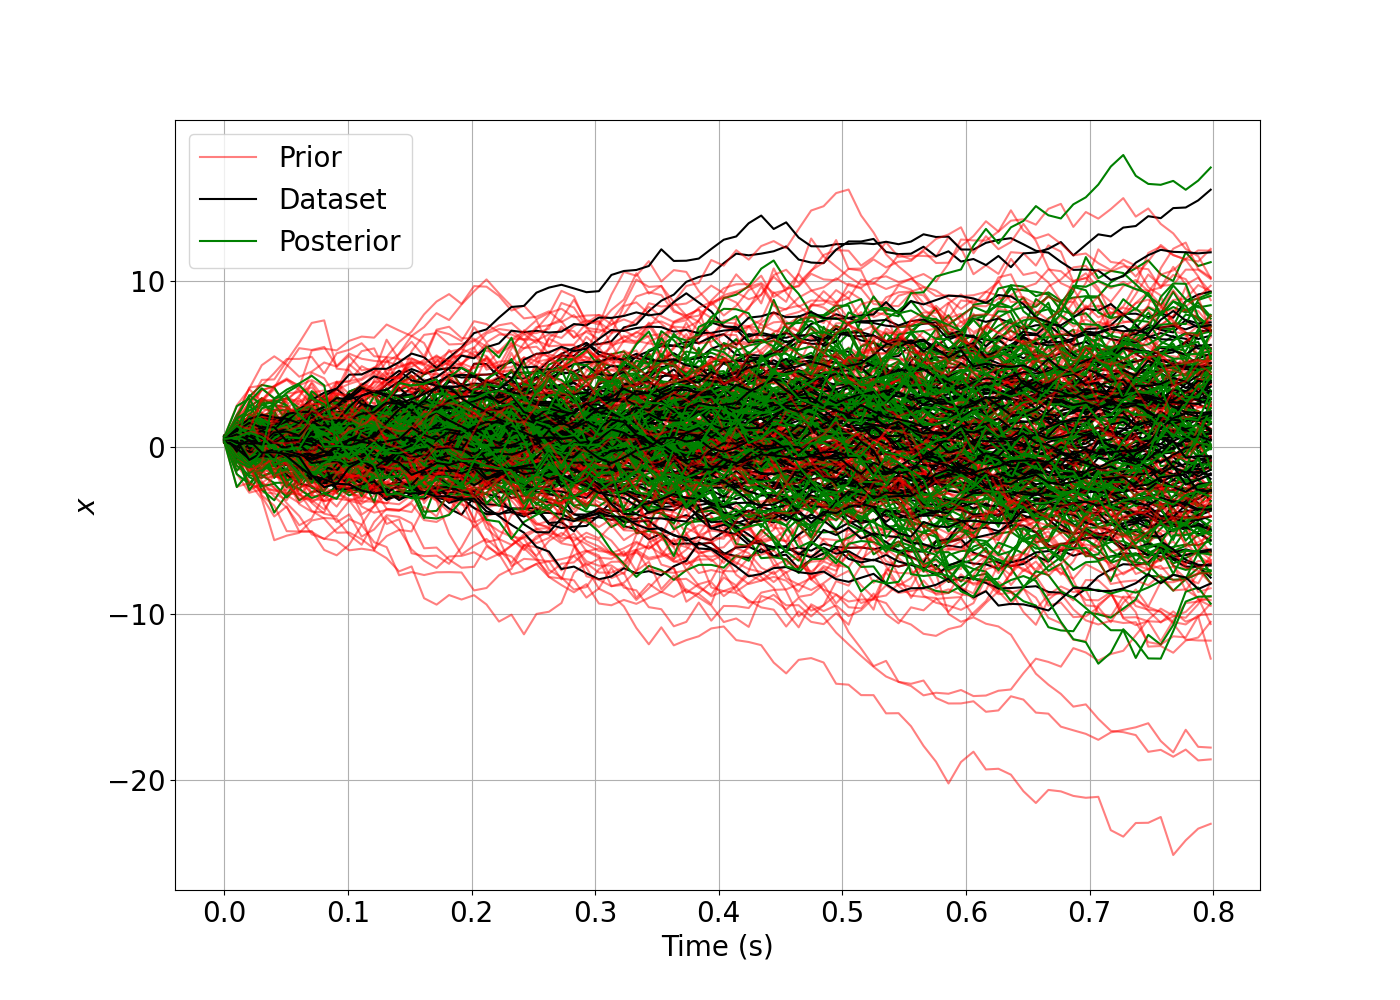

In [9]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(14, 10))
num_traj_plot = 100 # Maximum is set by the maximum of trajectories in the datase
for i in range(num_traj_plot):
    if i == 0:
        plt.plot(dataset_arr['t'][i,:80], ys_prior[i,0,:80,0], color='red', label='Prior', alpha=0.5)
        plt.plot(dataset_arr['t'][i,:80], dataset_arr['y'][i,:80,0], color='black', label='Dataset')
        plt.plot(dataset_arr['t'][i,:80], ys_posterior[i,0,:80,0], color='green', label='Posterior')
    else:
        plt.plot(dataset_arr['t'][i,:80], ys_prior[i,0,:80,0], color='red', alpha=0.5)
        plt.plot(dataset_arr['t'][i,:80], dataset_arr['y'][i,:80,0], color='black')
        plt.plot(dataset_arr['t'][i,:80], ys_posterior[i,0,:80,0], color='green')
plt.xlabel('Time (s)')
plt.ylabel('$x$')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# We take a trajectory
tevol, y0, uevol = dataset_arr['t'][1,:], dataset_arr['y'][1,0,:], dataset_arr['u'][1,:,:]
ys_prior = jit_prior_fn(tevol, y0, uevol, m_rng)
ys_posterior = jit_posterior_fn(tevol, y0, uevol, m_rng)

_stupid_params = {'sde_solver' : 'stratonovich_milstein', 'n_y' : 1, 'n_u' : 1, 'n_x' : 1, 'num_particles' : num_particles}
prior_params, sampling_fn = create_sampling_fn(_stupid_params, sde_constr=LinSDE, prior_sampling=True, seed=0)
ys_true = jax.jit(sampling_fn)(prior_params, tevol, y0, uevol, m_rng)

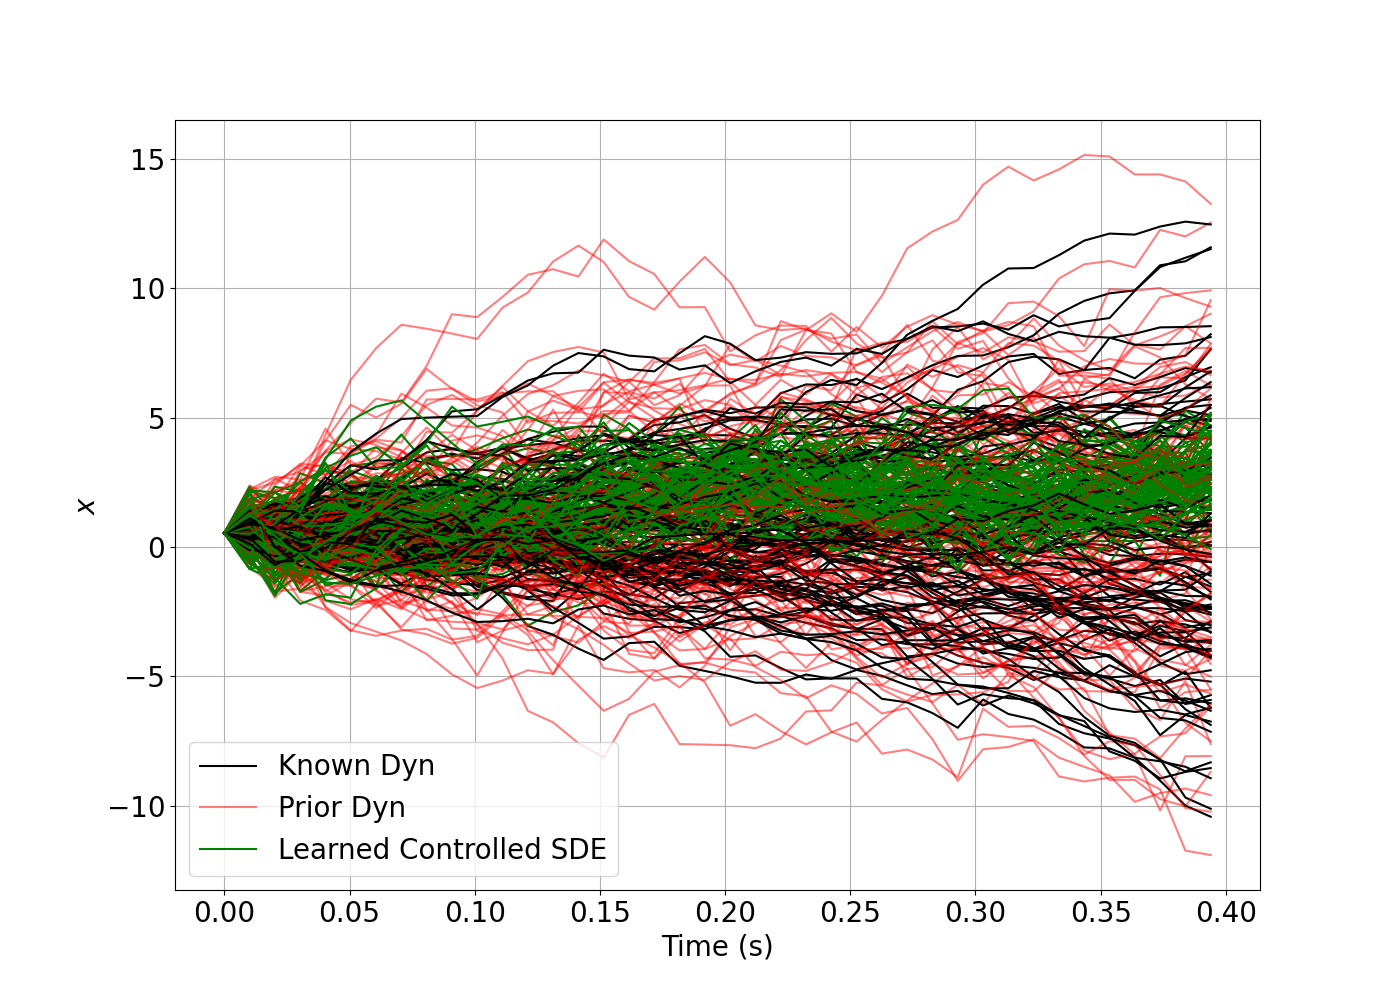

In [11]:
# Follow well on the learned integration horizon
fig, ax = plt.subplots(figsize=(14, 10))
for i in range(num_particles):
    if i == 0:
        plt.plot(tevol[:40], ys_true[i,:40,0], color='black', label= 'Known Dyn')
        plt.plot(tevol[:40], ys_prior[i,:40,0], color='red', label='Prior Dyn', alpha=0.5)
        plt.plot(tevol[:40], ys_posterior[i,:40,0], color='green', label='Learned Controlled SDE')
    else:
        plt.plot(tevol[:40], ys_true[i,:40,0], color='black')
        plt.plot(tevol[:40], ys_prior[i,:40,0], color='red', alpha=0.5)
        plt.plot(tevol[:40], ys_posterior[i,:40,0], color='green')
plt.xlabel('Time (s)')
plt.ylabel('$x$')
plt.legend()
plt.grid(True)
plt.show()